In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# check GPU availability
import torch
print("available devices count:", torch.cuda.device_count())
# disable CuDNN globally
torch.backends.cudnn.enabled = False

available devices count: 4


In [3]:
import torchvision
import numpy as np
transform = lambda x: torch.from_numpy(np.asarray(x, dtype=np.float32))
mnist_train_data = torchvision.datasets.MNIST("/tmp/mnist_data", train=True, download=True, transform=transform)
mnist_test_data = torchvision.datasets.MNIST("/tmp/mnist_data", train=False, download=True, transform=transform)

In [4]:
from snippets.scaffold import TrainLoop, TestLoop
from snippets.modules import MLP, Lambda, one_hot
from snippets.modules.bayesian import VAE
import torch
import torch.nn as nn
import torch.distributions as dist
# set a GPU device
torch.cuda.set_device(3)
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_data, 
                                                     batch_size=256, 
                                                     shuffle=True, 
                                                     drop_last=True, 
                                                     num_workers=16)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_data, 
                                                     batch_size=256, 
                                                     shuffle=False, 
                                                     drop_last=False, 
                                                     num_workers=16)
model = VAE(
    variational_net=nn.Sequential(Lambda(lambda x: torch.cat([x[0], x[1]], -1)), MLP(784 + 10, [256, 100])),
    generative_net=nn.Sequential(Lambda(lambda x: torch.cat([x[0], x[1]], -1)), MLP(2 + 10, [100, 256])),
    z_layers=nn.ModuleDict({"loc": nn.Linear(100, 2), "scale": nn.Sequential(nn.Linear(100, 2), nn.Softplus(), )}),
    x_layers=nn.ModuleDict({"probs": nn.Sequential(nn.Linear(256, 784), nn.Sigmoid())}),
    x_dist_cls=dist.Bernoulli,
    z_dist_cls=dist.Normal,
)
model.cuda()
z_prior = dist.Normal(torch.Tensor((0.,)).cuda(), torch.Tensor((1.,)).cuda())

optimizer = torch.optim.Adam(model.parameters())
# print(model)
with TrainLoop(max_epochs=50, use_cuda=True, disp_epoch_freq=5).with_context() as loop:
    for _ in loop.iter_epochs():
        for _, (x, y) in loop.iter_steps(mnist_train_dataloader):
            optimizer.zero_grad()
            loss = -model.elbo_sgvb(x.view(x.size()[0], -1) / 255, z_prior, one_hot(y, 10).type_as(x))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 10.)
            optimizer.step()
            loop.submit_metric("train_loss", loss.detach().cpu().numpy())

[epoch:5/50 step:1170 ETA:153.079s] train_loss: 154.320068(±42.748016) step_time(s): 0.010045(±0.007382) epoch_time(s): 3.401758(±0.222378)
[epoch:10/50 step:2340 ETA:138.878s] train_loss: 134.215485(±3.016551) step_time(s): 0.009979(±0.002010) epoch_time(s): 3.471955(±0.088051)
[epoch:15/50 step:3510 ETA:115.477s] train_loss: 131.767487(±2.821162) step_time(s): 0.009450(±0.001868) epoch_time(s): 3.299345(±0.226192)
[epoch:20/50 step:4680 ETA:102.624s] train_loss: 130.462387(±2.754795) step_time(s): 0.010036(±0.002097) epoch_time(s): 3.420799(±0.268395)
[epoch:25/50 step:5850 ETA:82.581s] train_loss: 129.579727(±2.762206) step_time(s): 0.009357(±0.001985) epoch_time(s): 3.303257(±0.244285)
[epoch:30/50 step:7020 ETA:70.106s] train_loss: 128.911972(±2.821562) step_time(s): 0.009954(±0.001688) epoch_time(s): 3.505283(±0.121624)
[epoch:35/50 step:8190 ETA:49.388s] train_loss: 128.356781(±2.850426) step_time(s): 0.009272(±0.001789) epoch_time(s): 3.292540(±0.274000)
[epoch:40/50 step:9360 

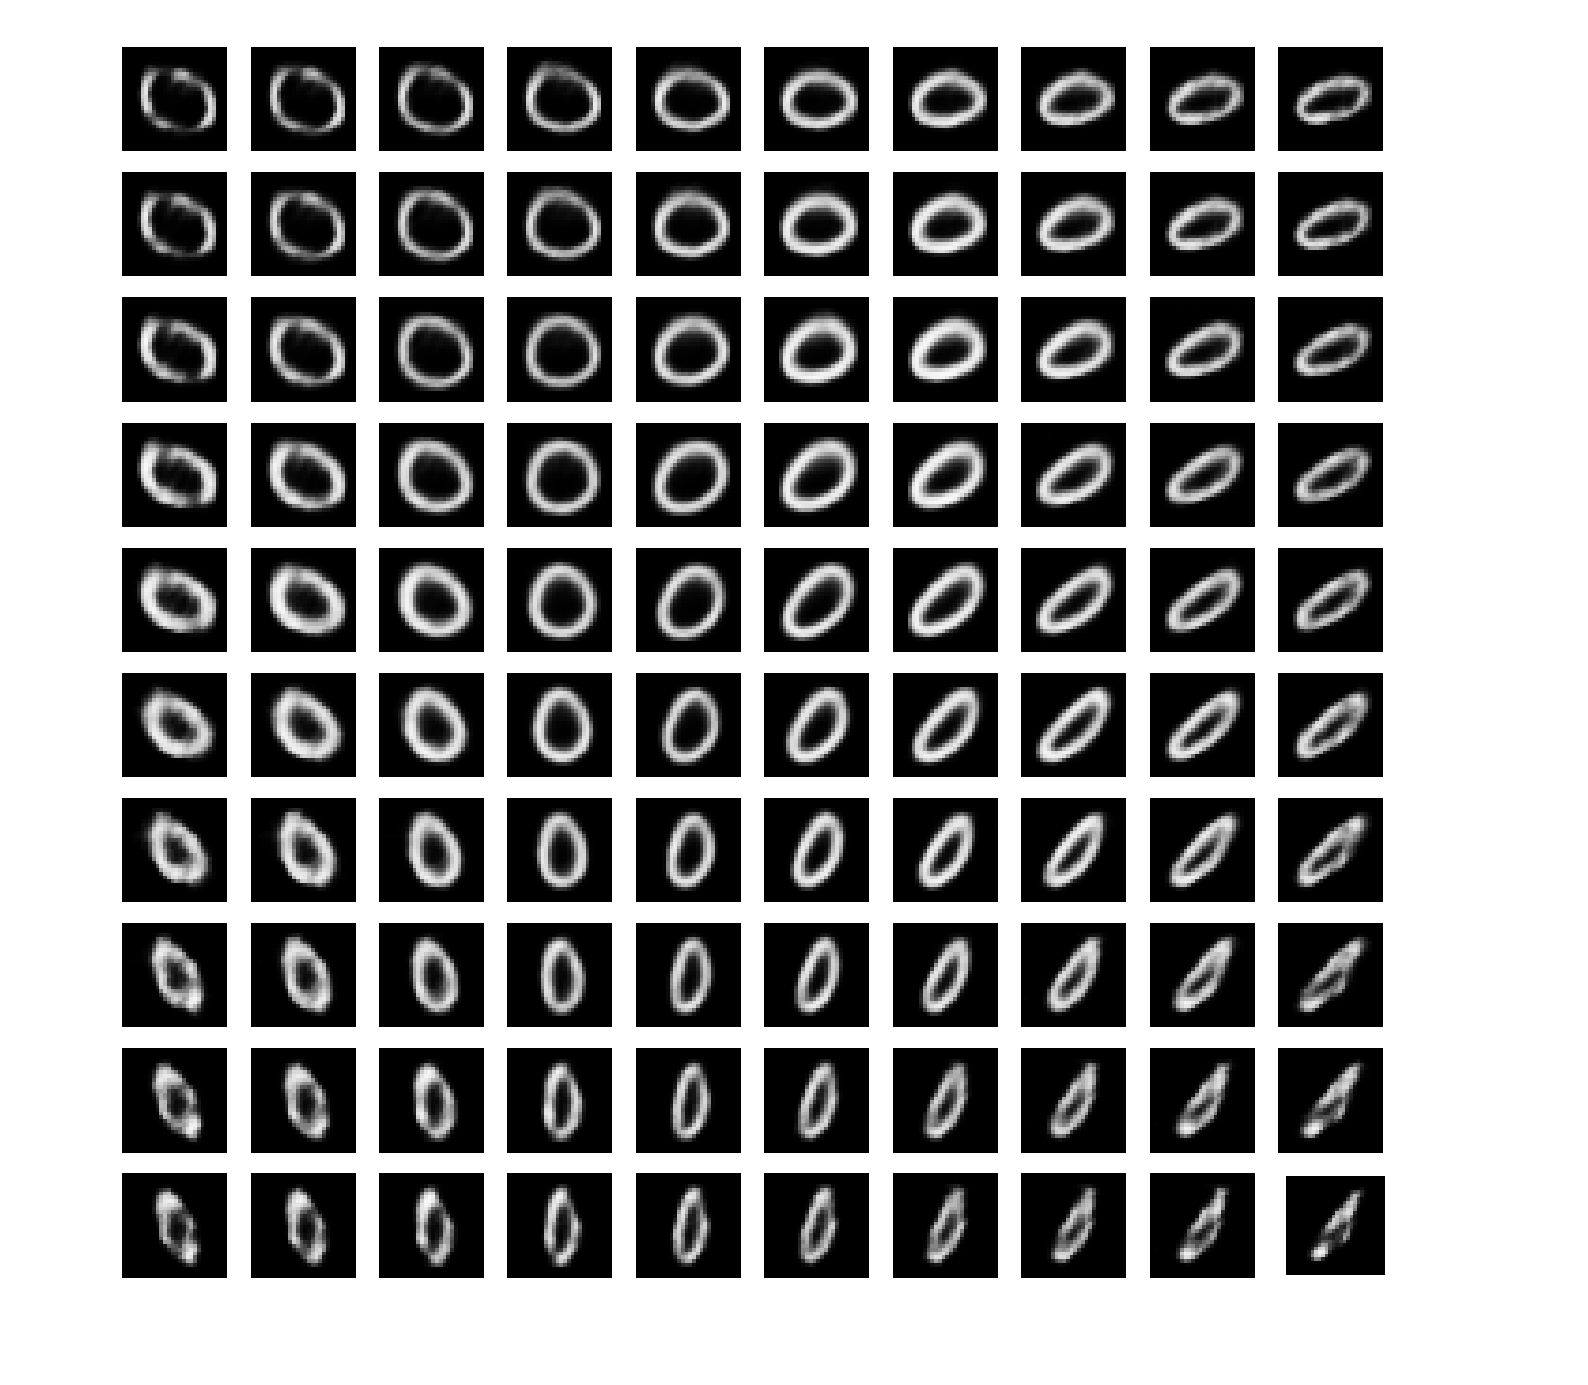

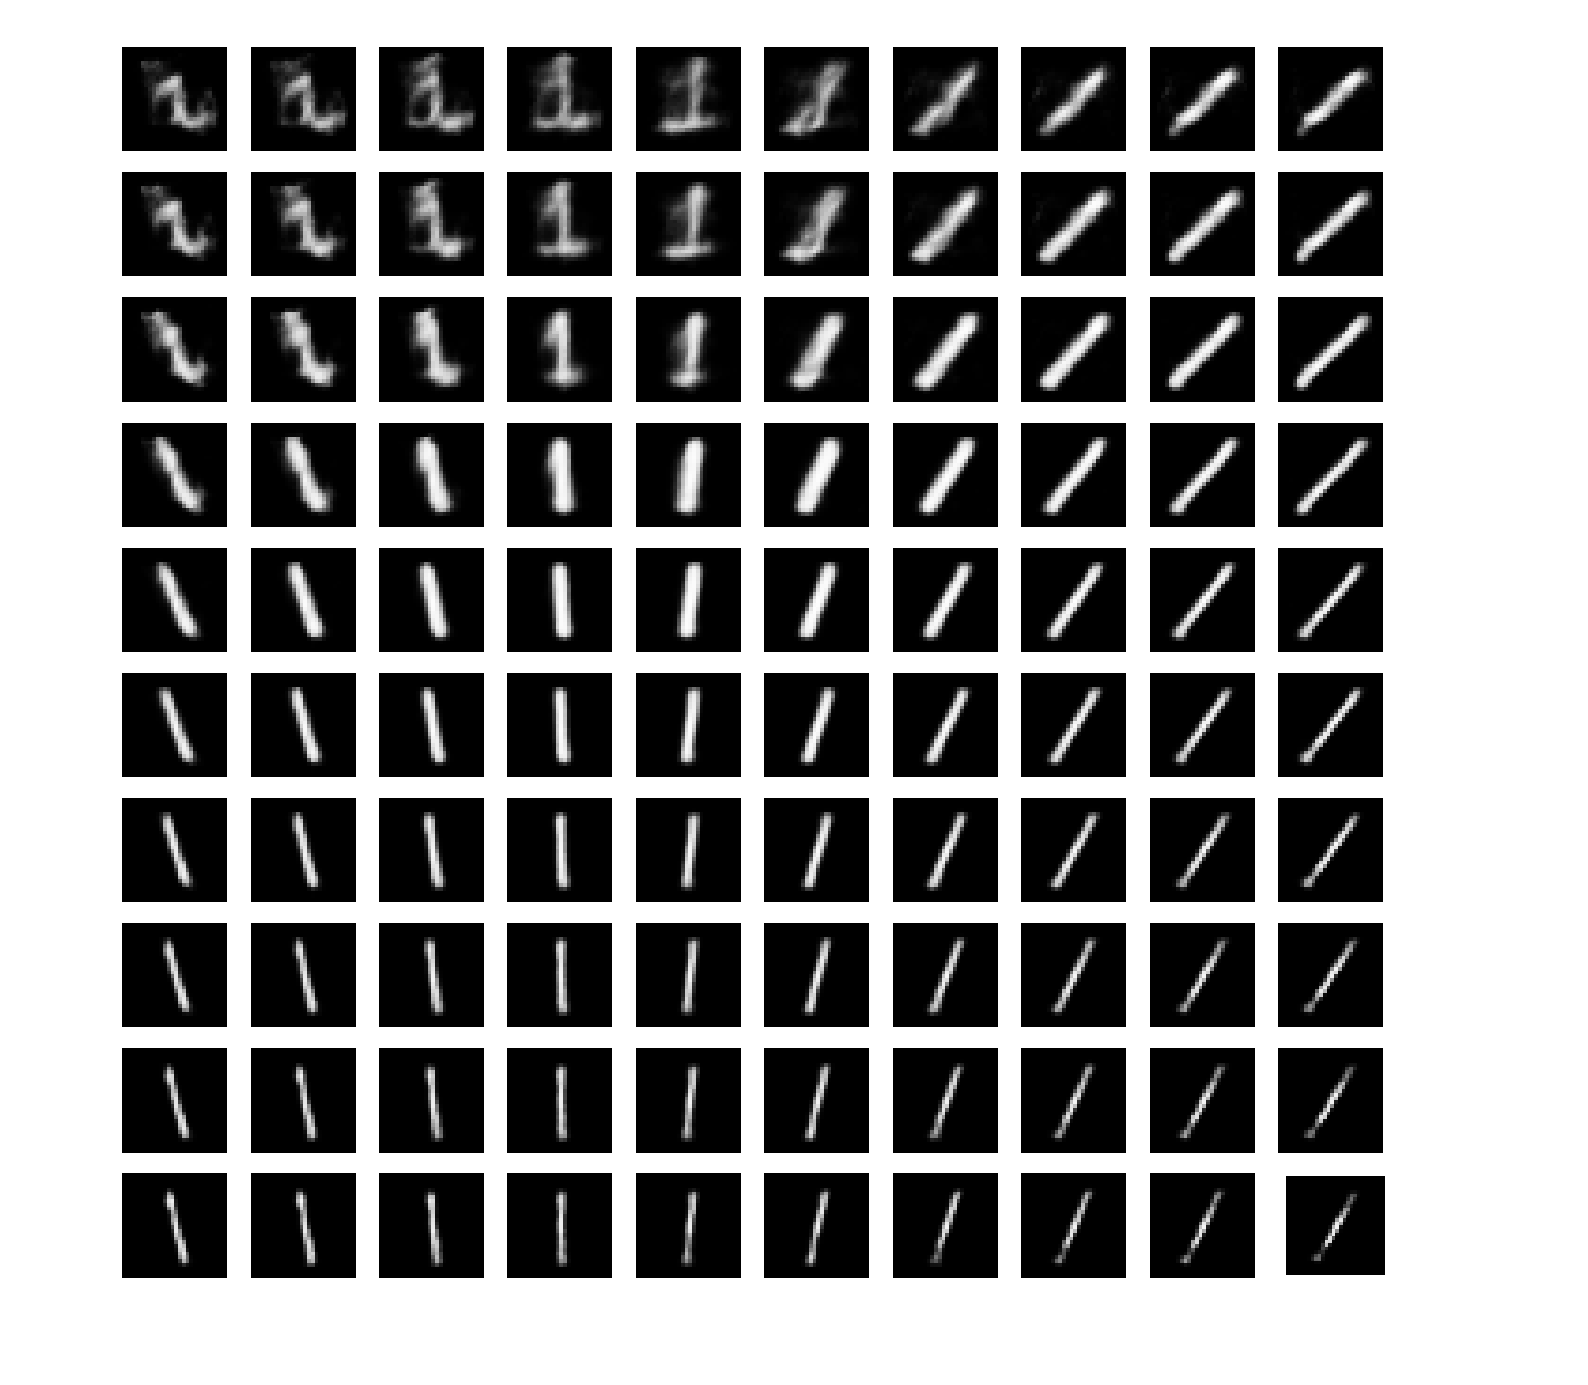

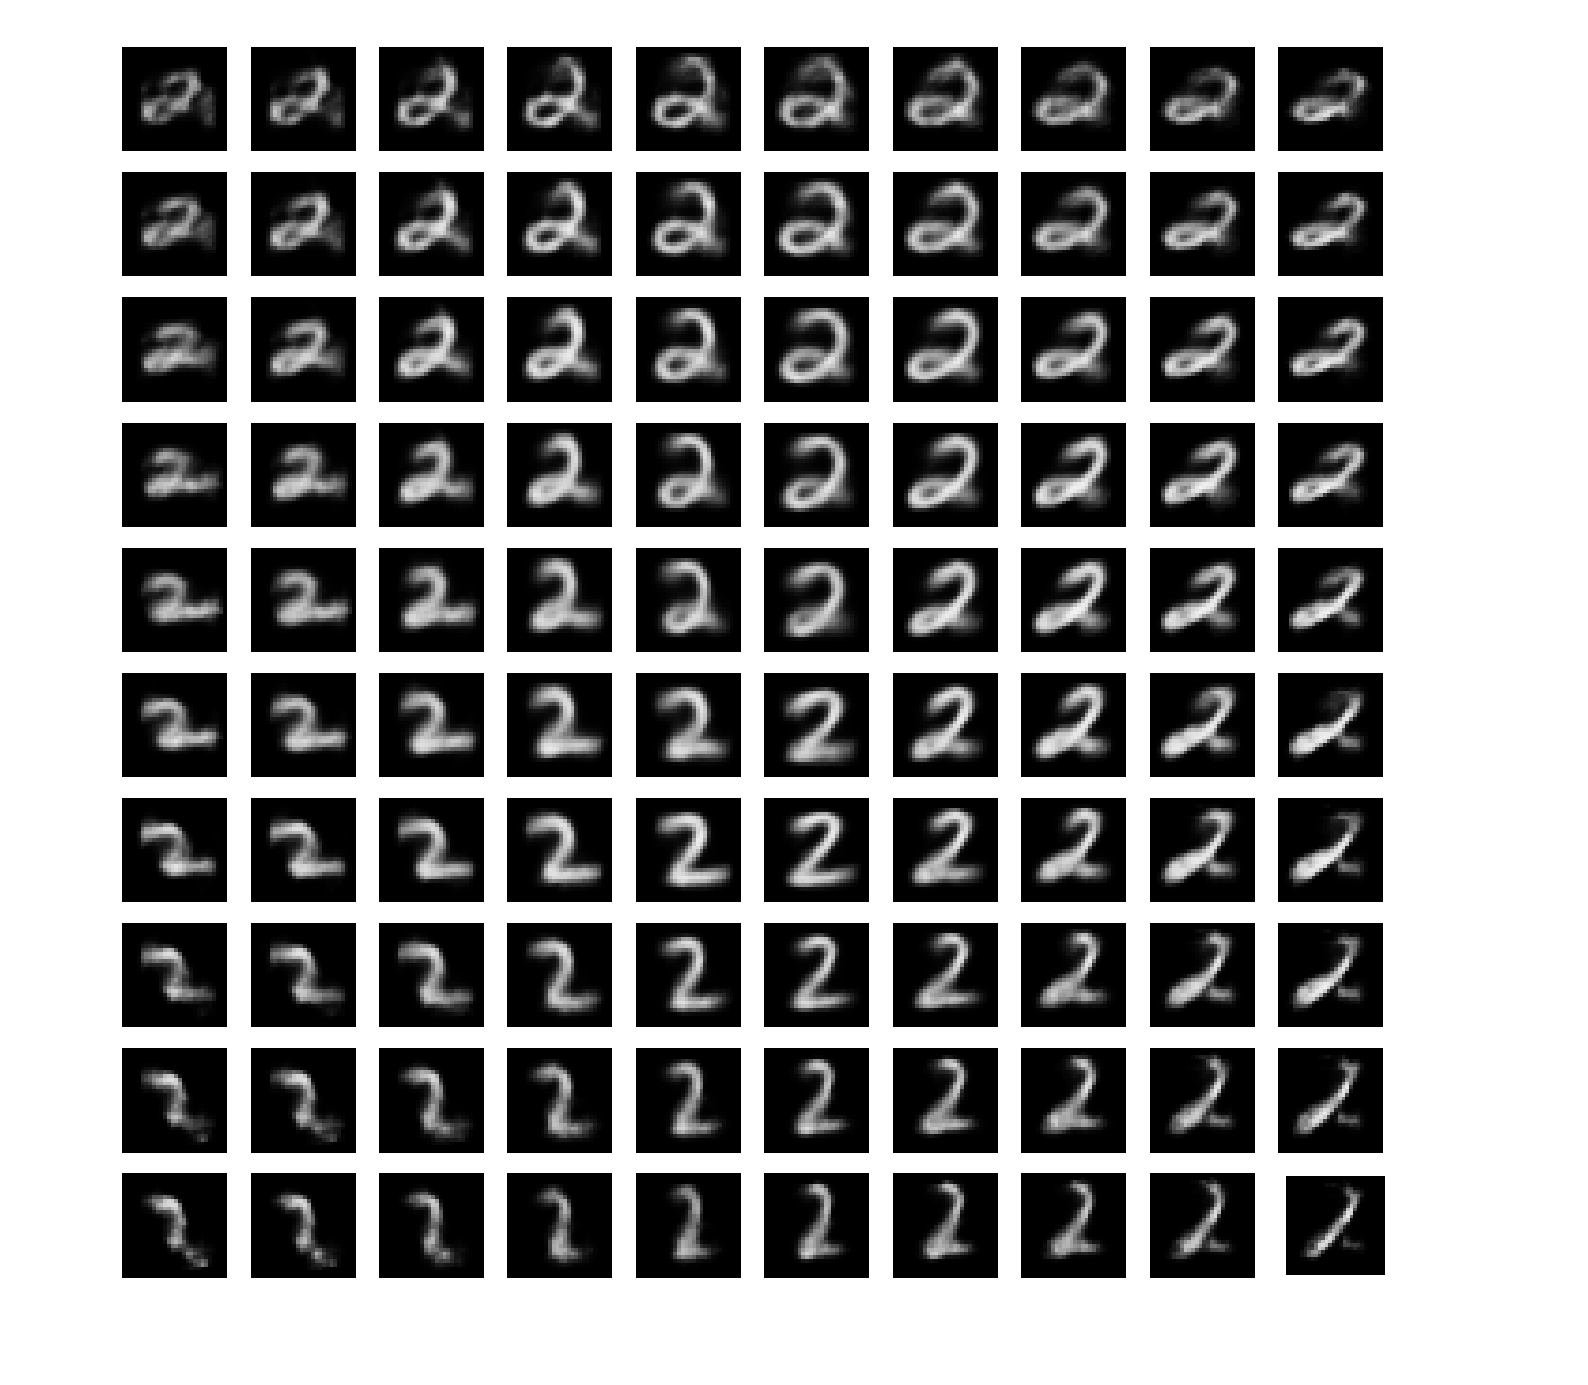

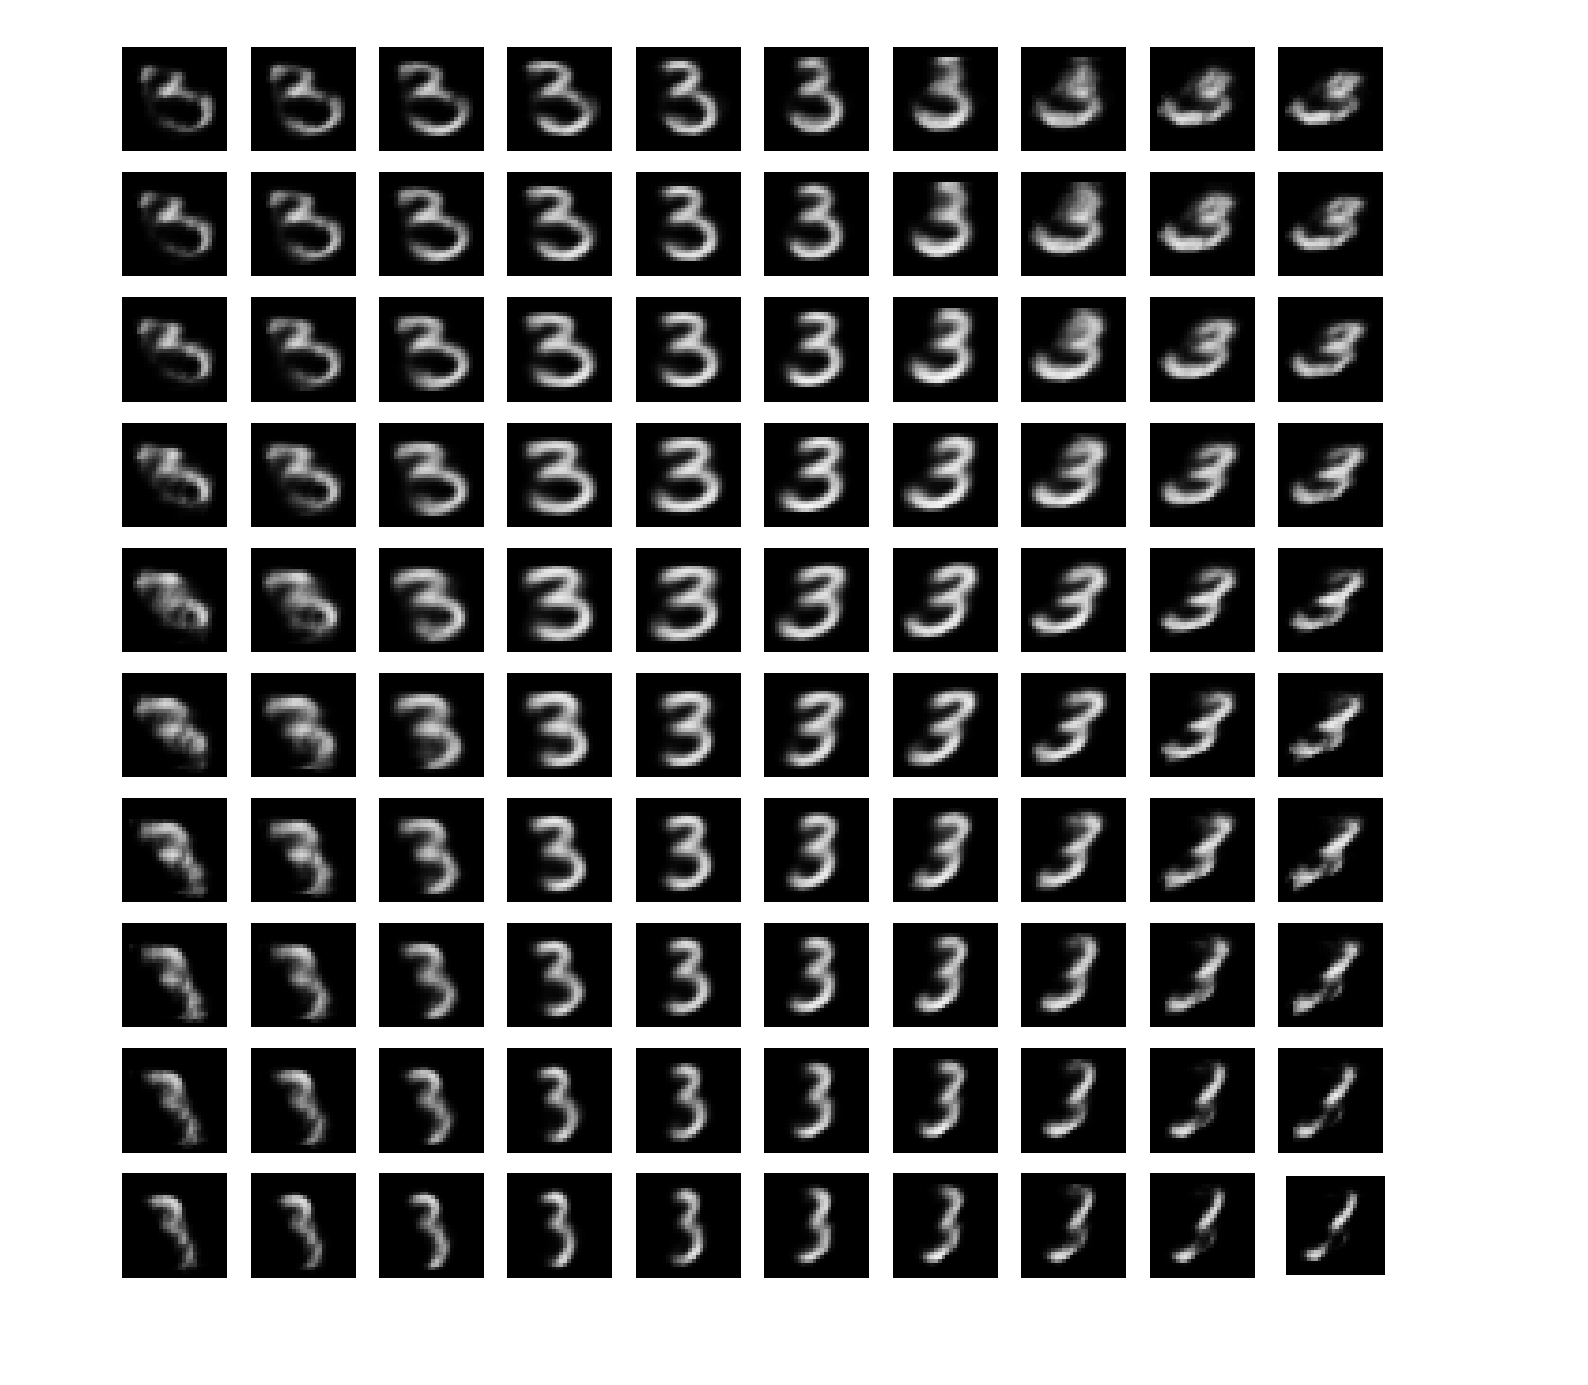

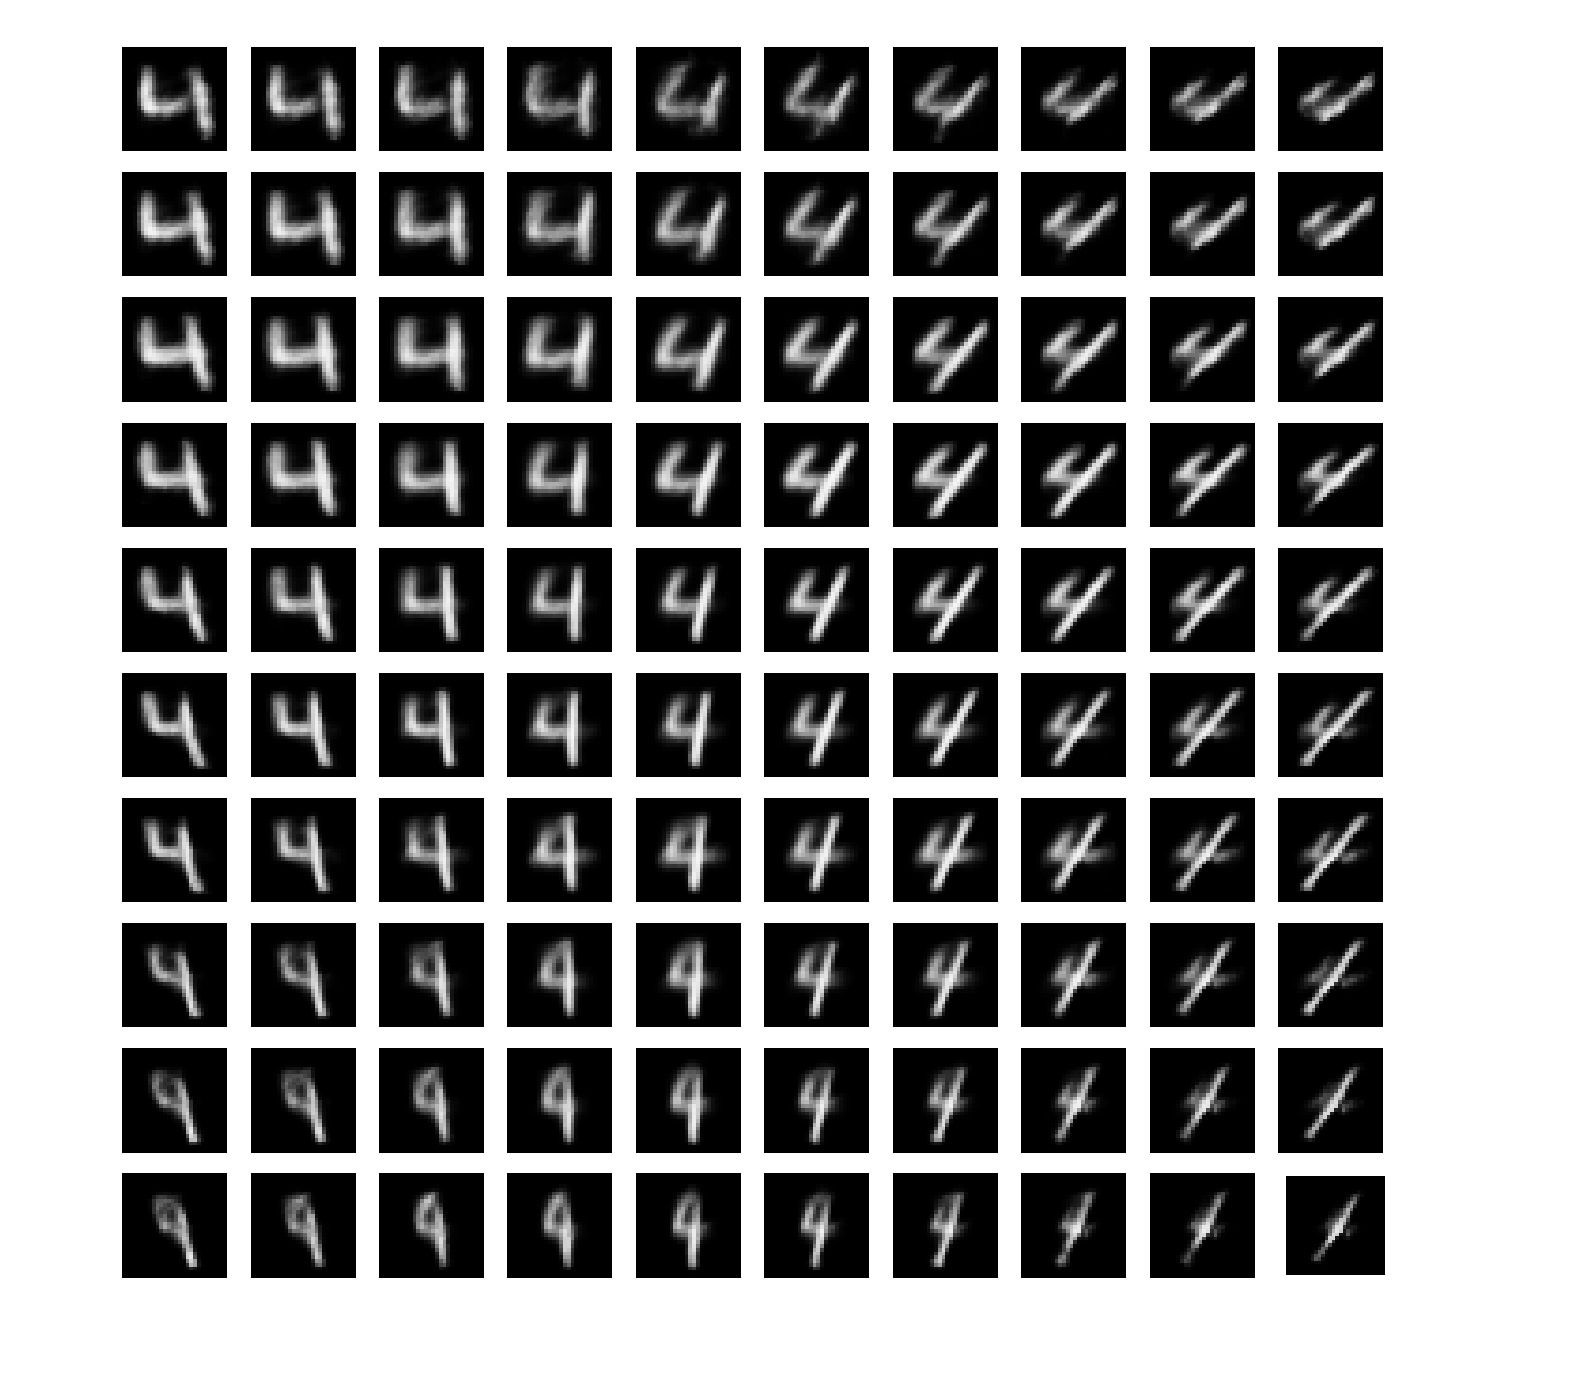

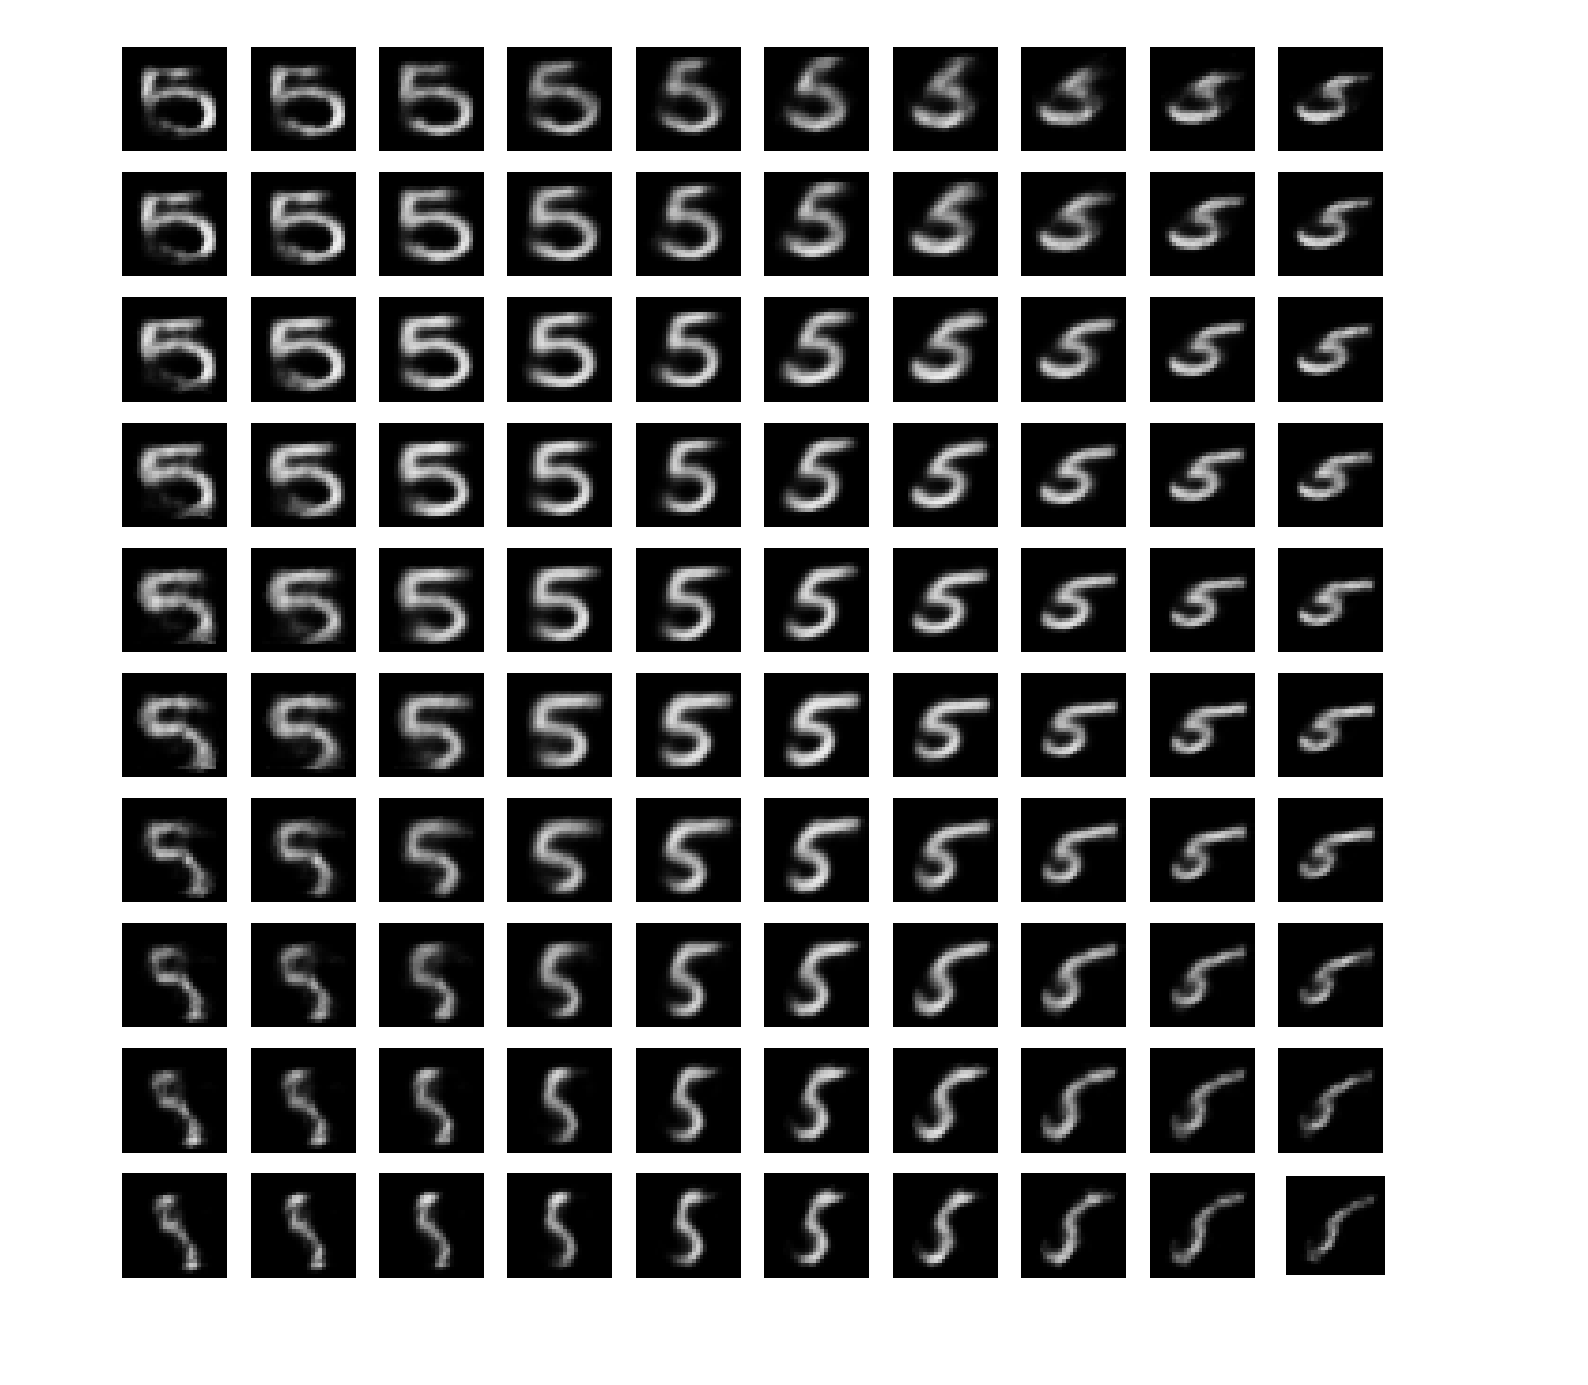

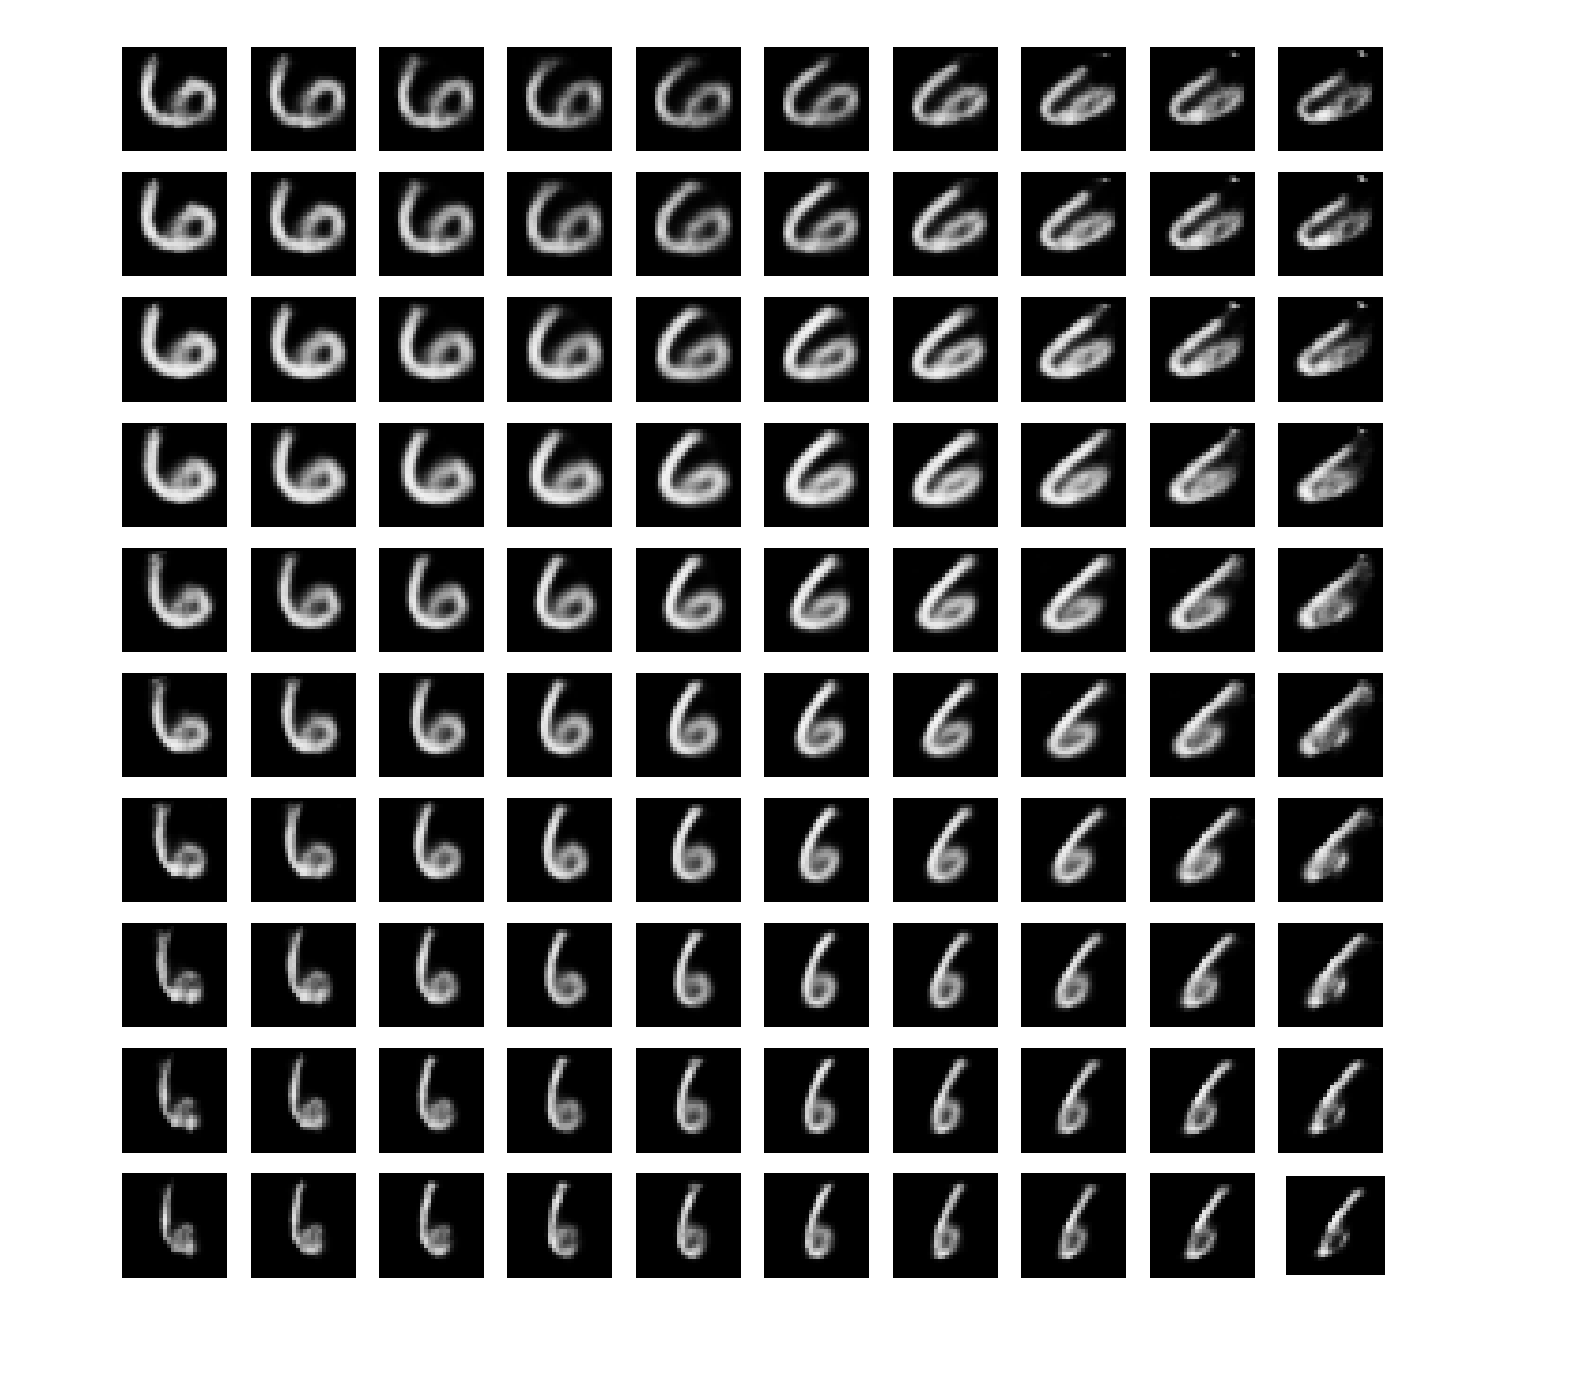

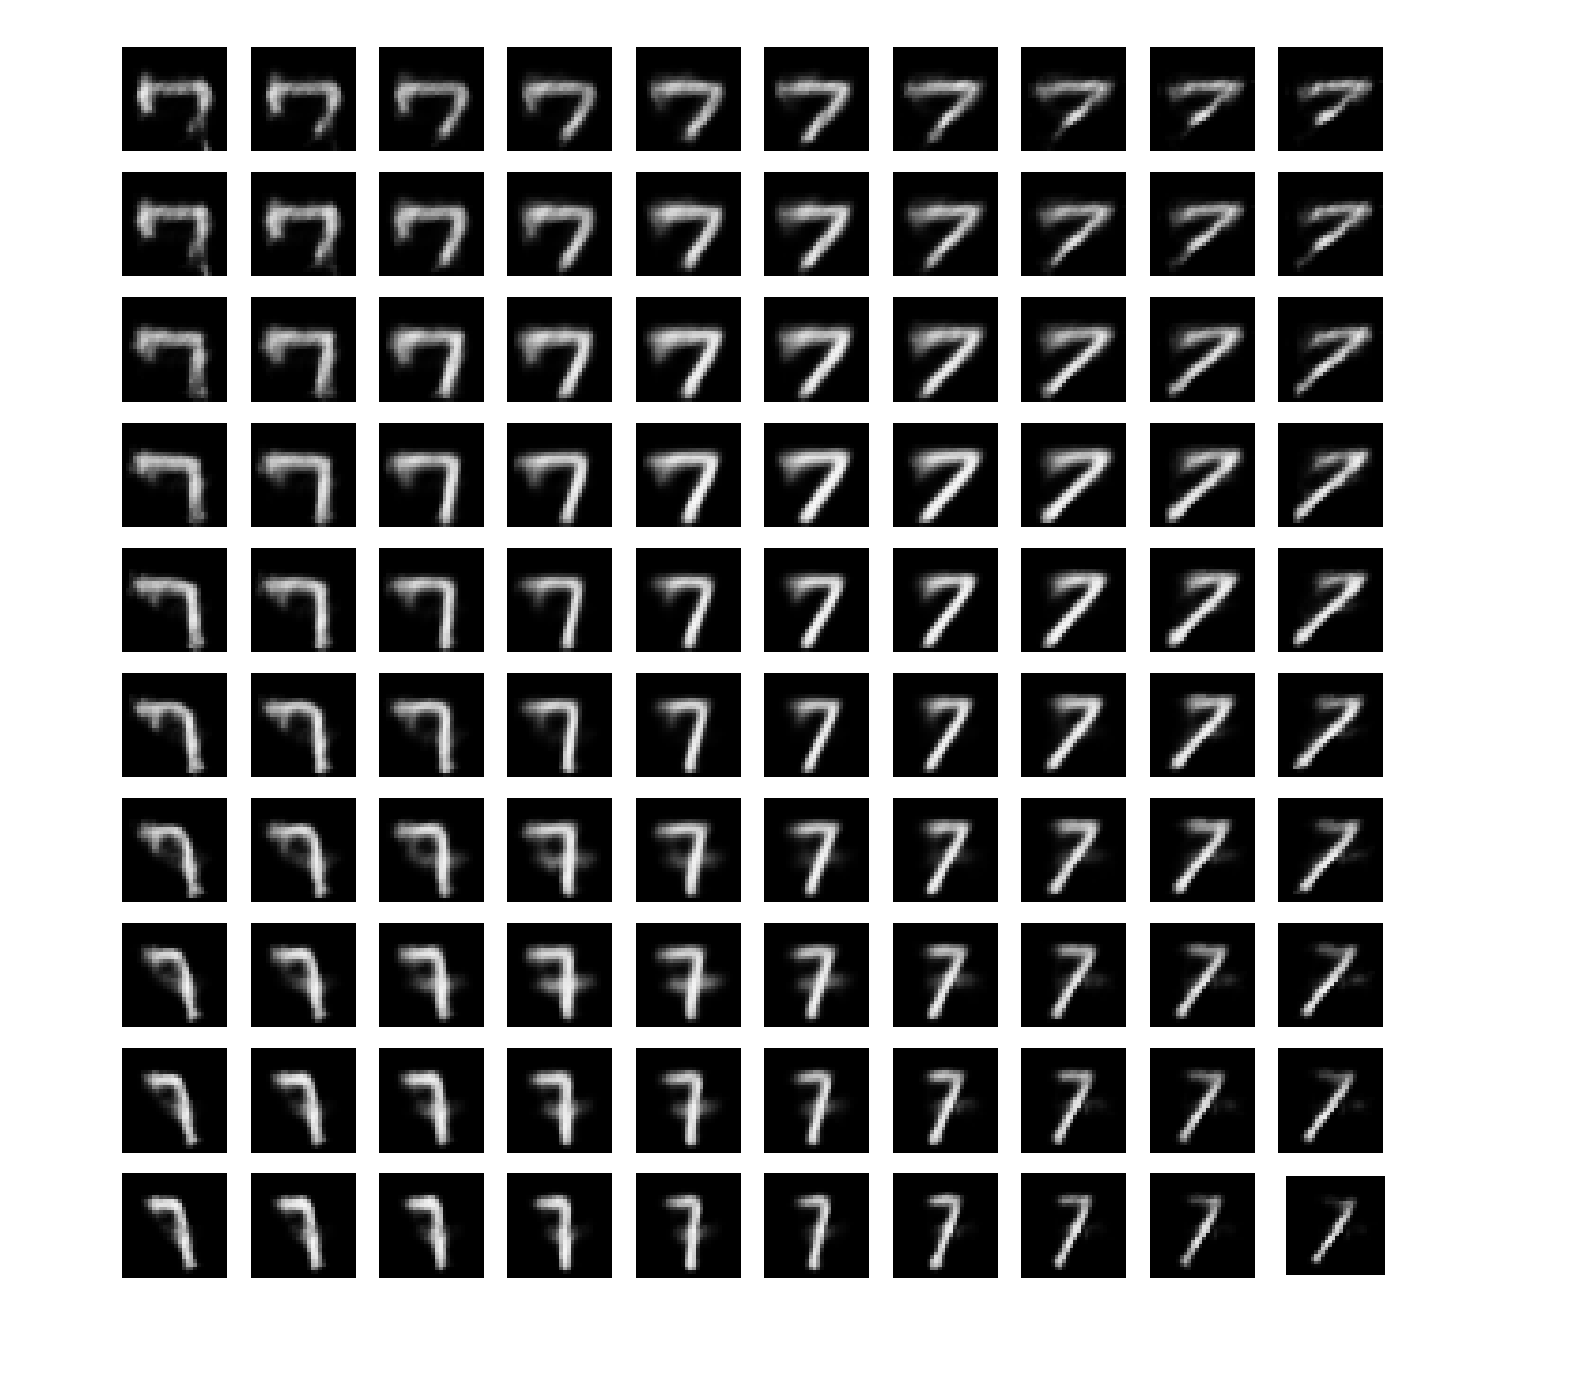

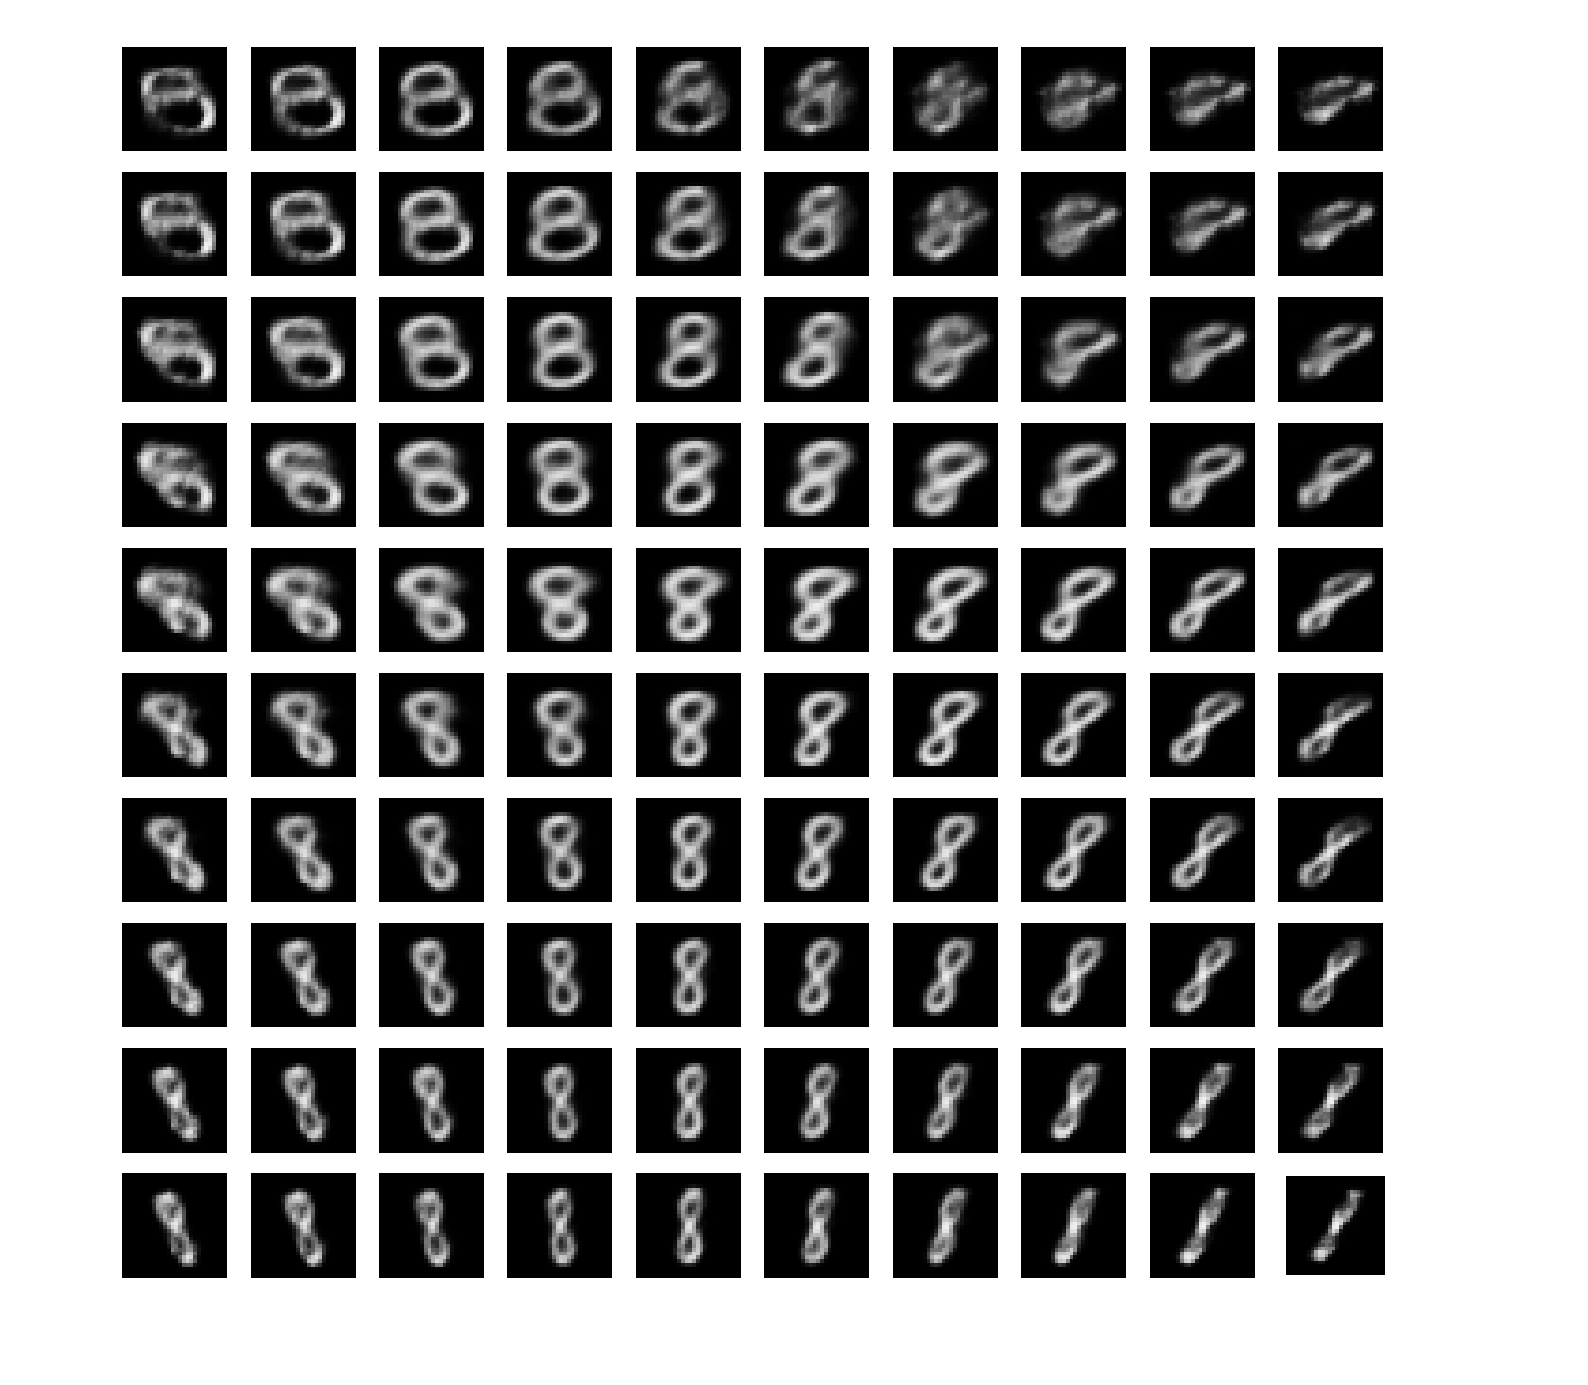

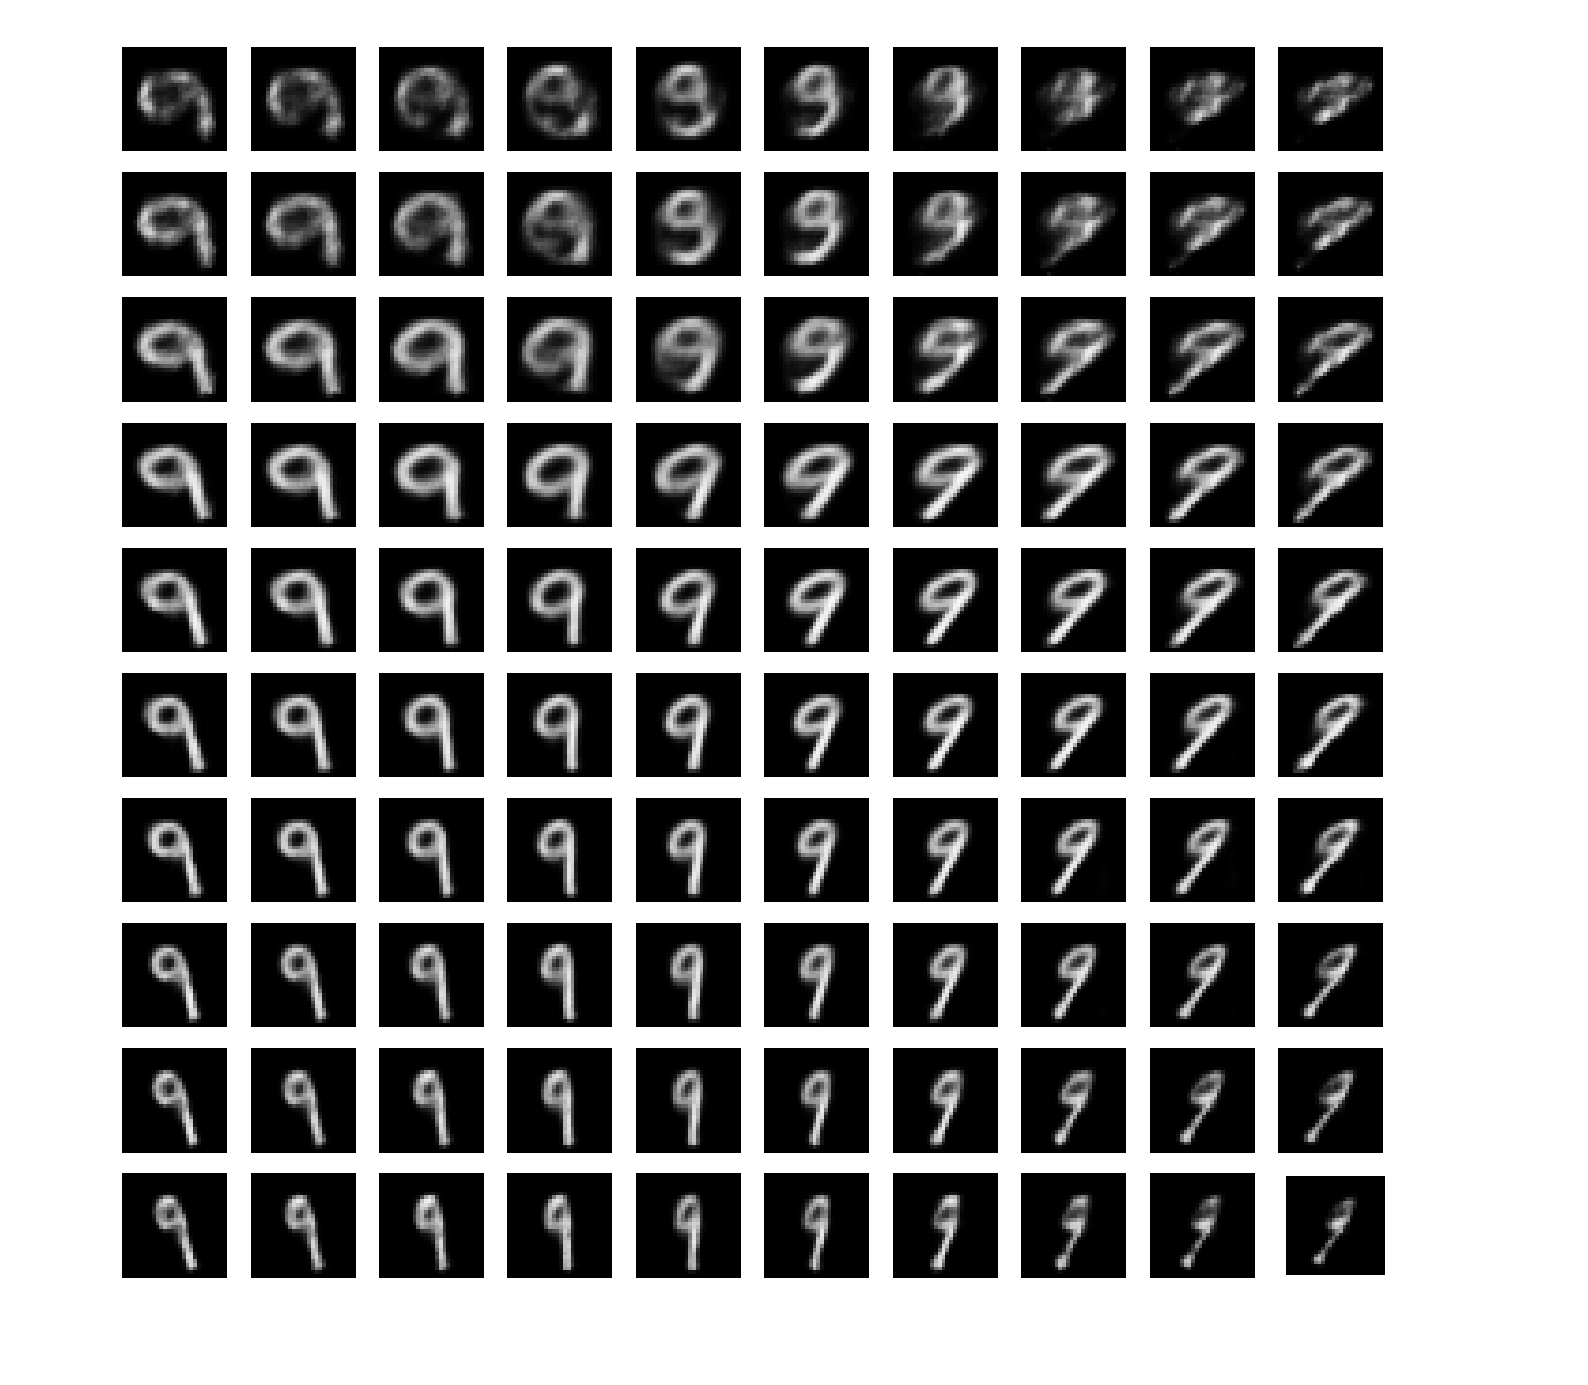

In [5]:
import matplotlib.pyplot as plt
import PIL
for number in range(10):
    idx = 0
    fig = plt.figure(figsize=(5, 5), dpi=326)
    x_list = np.linspace(-3, 3, 10)
    y_list = np.linspace(-3, 3, 10)
    with torch.no_grad():
        for i in x_list:
            for j in y_list:
                idx += 1
                ax = plt.subplot(10, 10, idx)
                ax.axis("off")
                z = torch.Tensor((i, j)).cuda()
                y = one_hot(torch.Tensor((number,)), 10).type_as(z).squeeze(0)
                x_dist = model.decode(z, y)
                img = x_dist.probs.view(28, 28)
                ax.imshow(PIL.Image.fromarray((img.cpu().numpy() * 255).astype(np.uint8), mode="L"))
    plt.xticks(x_list, [str(_) for _ in x_list])
    plt.show()
    plt.close("all")